In [1]:
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import textwrap

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

C:\Users\sthor\anaconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
classifier = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
C:\Users\sthor\anaconda3\envs\NLP\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sthor\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en

In [4]:
classifier("This is a great movie", candidate_labels=["positive", "negative"])

{'sequence': 'This is a great movie',
 'labels': ['positive', 'negative'],
 'scores': [0.9969461560249329, 0.0030538318678736687]}

In [5]:
# https://en.wikipedia.org/wiki/AMP-activated_protein_kinase
text = "Due to the presence of isoforms of its components, there are 12 " + \
  "versions of AMPK in mammals, each of which can have different tissue " + \
  "localizations, and different functions under different conditions. " + \
  "AMPK is regulated allosterically and by post-translational " + \
  "modification, which work together."
classifier(text, candidate_labels=["biology", "math", "geology"])

{'sequence': 'Due to the presence of isoforms of its components, there are 12 versions of AMPK in mammals, each of which can have different tissue localizations, and different functions under different conditions. AMPK is regulated allosterically and by post-translational modification, which work together.',
 'labels': ['biology', 'math', 'geology'],
 'scores': [0.8908602595329285, 0.06606585532426834, 0.043073881417512894]}

In [2]:
df = pd.read_csv('../bbc_text_cls.csv')

In [7]:
len(df)

2225

In [8]:
df.sample(frac=1).head()

,text,labels
1501,Rovers reject third Ferguson bid\n\nBlackburn ...,sport
75,Palestinian economy in decline\n\nDespite a sh...,business
893,Robots march to US cinema summit\n\nAnimated m...,entertainment
1541,McClaren targets Champions League\n\nMiddlesbr...,sport
1691,Ireland call up uncapped Campbell\n\nUlster sc...,sport


In [9]:
labels = list(set(df['labels']))
labels

['politics', 'entertainment', 'sport', 'business', 'tech']

In [10]:
print(textwrap.fill(df.iloc[1024]['text']))

UK troops on Ivory Coast standby  Downing Street has confirmed British
troops are on standby in case they need to help evacuate several
hundred UK citizens from Ivory Coast.  The news came as it emerged
France had begun evacuating its hostages after days of anti-French
demonstrations. Trouble flared after nine French peacekeepers were
killed and President Jacques Chirac ordered the destruction of the
Ivory Coast's air force. A company of 100-120 UK troops is understood
to have been put on standby. They are ready to fly out and secure the
route from the embassy to the airport if called upon. Prime Minister
Tony Blair's official spokesman said: "There are British nationals in
Ivory Coast and as you can imagine we are making the usual contingency
plans in case the situation deteriorates further, but that's all I can
say at this stage."  He added the situation would be monitored
carefully in case evacuation became necessary. France has played a
lead role in international peacekeeping in Iv

In [11]:
df.iloc[1024]['labels']

'politics'

In [12]:
classifier(df.iloc[1024]['text'], candidate_labels=labels)

{'sequence': 'UK troops on Ivory Coast standby\n\nDowning Street has confirmed British troops are on standby in case they need to help evacuate several hundred UK citizens from Ivory Coast.\n\nThe news came as it emerged France had begun evacuating its hostages after days of anti-French demonstrations. Trouble flared after nine French peacekeepers were killed and President Jacques Chirac ordered the destruction of the Ivory Coast\'s air force. A company of 100-120 UK troops is understood to have been put on standby. They are ready to fly out and secure the route from the embassy to the airport if called upon. Prime Minister Tony Blair\'s official spokesman said: "There are British nationals in Ivory Coast and as you can imagine we are making the usual contingency plans in case the situation deteriorates further, but that\'s all I can say at this stage."\n\nHe added the situation would be monitored carefully in case evacuation became necessary. France has played a lead role in internati

In [ ]:
# Takes about 55min
preds = classifier(df['text'].tolist(), candidate_labels=labels)

In [14]:
len(preds)

2225

In [16]:
preds[:5]

[{'sequence': 'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and w

In [17]:
predicted_labels = [d['labels'][0] for d in preds]

In [19]:
df['predicted_labels'] = predicted_labels

In [20]:
print("Acc:", np.mean(df['predicted_labels'] == df['labels']))

Acc: 0.5649438202247191


In [21]:
# Convert prediction probs into an NxK matrix according to
# original label order

N = len(df)
K = len(labels)
label2idx = {v:k for k,v in enumerate(labels)}

In [23]:
label2idx 

{'politics': 0, 'entertainment': 1, 'sport': 2, 'business': 3, 'tech': 4}

In [21]:
probs = np.zeros((N, K))
for i in range(N):
  # loop through labels and scores in corresponding order
  d = preds[i]
  for label, score in zip(d['labels'], d['scores']):
    k = label2idx[label]
    probs[i, k] = score

In [24]:
int_labels = [label2idx[x] for x in df['labels']]

In [34]:
print(int_labels[:200])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [35]:
int_preds = np.argmax(probs, axis=1)
cm = confusion_matrix(int_labels, int_preds, normalize='true')

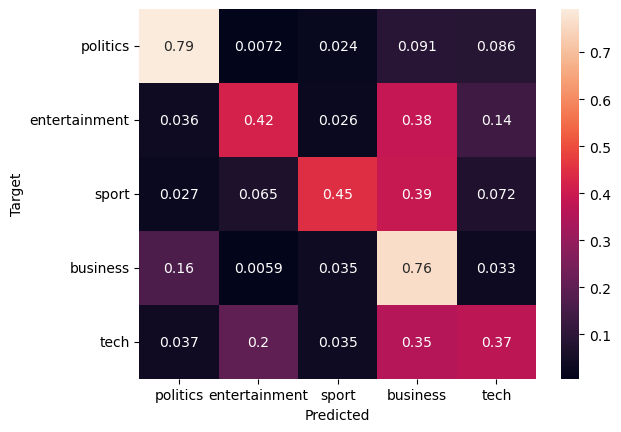

In [36]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  ax = sn.heatmap(df_cm, annot=True, fmt='.2g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)